# X-Ray Pneumonia Diagnosis

This project focuses on analyzing a series of X-ray images to categorize pneumonia diagnoses into three classes: no illness, bacterial infection, and viral infection. The pipeline includes data analysis, preprocessing, and the implementation of a neural network for classification. Additionally, explainable AI techniques are utilized to enhance the interpretability of the model's predictions.

# Setup and Imports
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [5]:
import os
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
import csv
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve



# Data Analysis

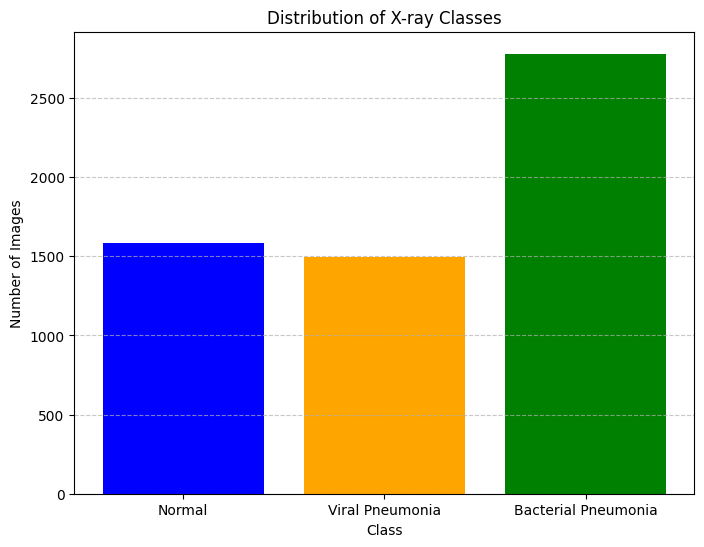

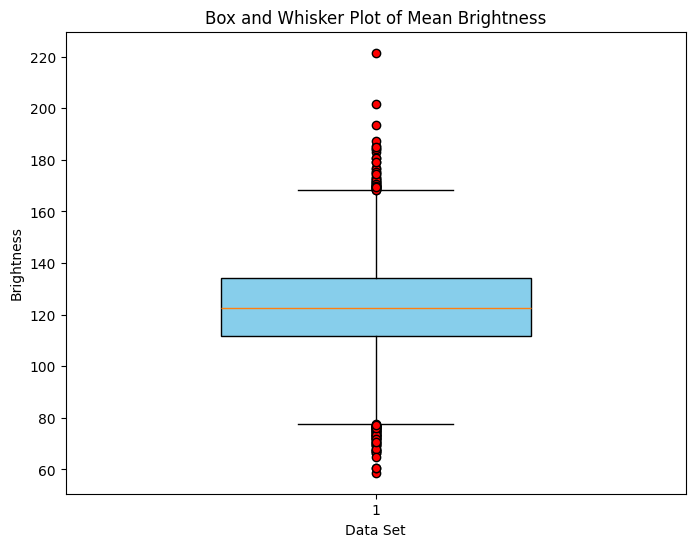

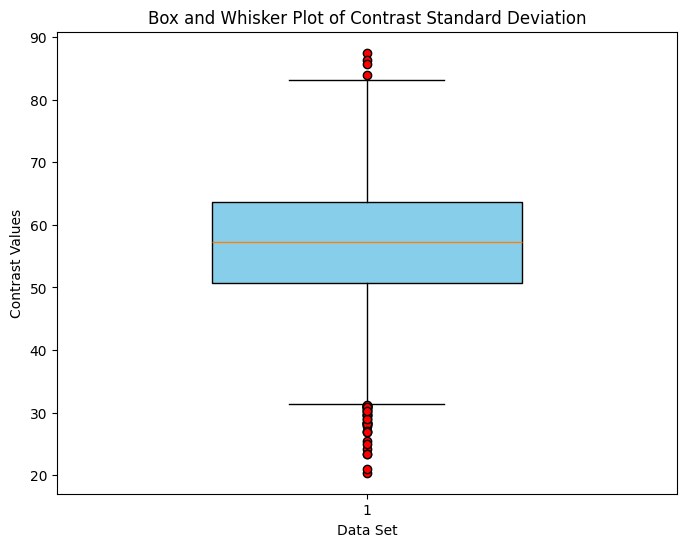

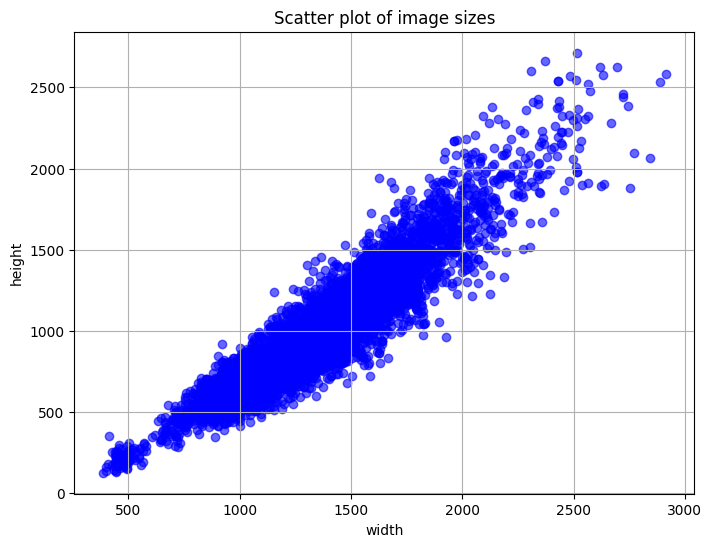

In [6]:
# Average brightness, Standard deviation (both individually per file and for all), Contrast/Dynamic range, Median brightness

# Function to calculate brightness
def calculate_brightness(image):
    grayscale_image = image.convert("L")  # Convert to grayscale
    np_image = np.array(grayscale_image)
    brightness = np.mean(np_image)  # Average pixel value represents brightness
    return brightness

# Calculate the standard deviation of the contrast
def calculate_contrast(image):
    grayscale_image = image.convert("L") # Convert to grayscale
    contrast = np.std(grayscale_image)
    return contrast

# Iterates through all the files in a folder to run different functions for stats
def run_for_stats(folder_path):
    brightness_values = []
    contrast_values = []
    x = []
    y = []
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".jpeg"):
                #print("ran")
                file_path = os.path.join(root, filename)
                with Image.open(file_path) as img:
                    brightness = calculate_brightness(img)
                    brightness_values.append(brightness)
                    contrast = calculate_contrast(img)
                    contrast_values.append(contrast)
                    width, height = img.size
                    x.append(width)
                    y.append(height)
    return brightness_values, contrast_values, x, y                

def box_whiskers(data, title, y_axis):
    """
    Plot a box and whisker plot without any scatter plot of data points.
    
    Args:
    - data (array-like): A list or array of numerical data.
    """
    # Create a figure and axis
    plt.figure(figsize=(8, 6))
    
    # Create the boxplot
    plt.boxplot(data, positions=[1], widths=0.5, patch_artist=True, 
                boxprops=dict(facecolor='skyblue', color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor='red', marker='o', markersize=6))
    
    # Adding title and labels
    plt.title(title)
    plt.xlabel("Data Set")
    plt.ylabel(y_axis)
    
    # Show the plot
    plt.show()

# Makes a scatterplot (for the size of the images)
def scatter(x_data, y_data, title, y_name, x_name):
    """
    Plots a scatter plot using x_data for the x-axis and y_data for the y-axis.
    
    Args:
    - x_data (array-like): Data for the x-axis.
    - y_data (array-like): Data for the y-axis.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, color='blue', alpha=0.6, marker='o')
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.grid(True)
    plt.show()
    return

def run_all(path):
    brightness_values, contrast_values, x, y = run_for_stats(path)
    box_whiskers(brightness_values, "Box and Whisker Plot of Mean Brightness", "Brightness")
    box_whiskers(contrast_values, "Box and Whisker Plot of Contrast Standard Deviation", "Contrast Values")
    scatter(x,y,"Scatter plot of image sizes", "height", "width")
    return

def countClasses(folder_path):
    normal = 0
    viral = 0
    bacterial = 0
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".jpeg"):
                if 'virus' in filename:
                    viral += 1
                elif 'bacteria' in filename:
                    bacterial += 1
                else:
                    normal += 1
    classes = ['Normal', 'Viral Pneumonia', 'Bacterial Pneumonia']
    counts = [normal, viral, bacterial]

    # Create the bar graph
    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color=['blue', 'orange', 'green'])
    plt.title('Distribution of X-ray Classes')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    return

path = 'ChestXRay2017'

countClasses(path)
run_all(path)

# Single Model Ensemble Performance Analysis

In [7]:
# Some setup used for all model evaluations
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()  # Convert images to PyTorch tensors

In [8]:
# Define the custom Dataset class to handle image loading, used for all models
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['Paths']
        label = self.data.iloc[idx]['Labels']
        image = Image.open(image_path)  # Image is already grayscale
       
        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
# Declaring Model structure for the single model ensemble
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
       
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)  # Input is grayscale (1 channel)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
       
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(26 * 26 * 128, 128)  # Flattened size from last pooling layer
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 3)  # Output layer for 3 classes
        
    def forward(self, x):
        # Forward pass through convolutional and pooling layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
       
        # Flatten and pass through fully connected layers
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
# Defines the function used to split the data for full ensemble models
# This train_test_split creates 2 sets of train/test for the binary classification breakdowns, takes in 'Normalized_Image_Paths.csv'
def train_test_split(file_path,test_size):
    # Load the data
    data = pd.read_csv(file_path)

    # Check the label distribution
    label_counts = data['Labels'].value_counts()
    min_class_count = label_counts.min()
   
    # Create a balanced sample for each label to achieve roughly 33.3% of each label in train and test sets
    data_balanced = pd.concat([
        data[data['Labels'] == label].sample(min_class_count, random_state=42)
        for label in data['Labels'].unique()
    ])

    # Split the balanced data into training and testing sets with a split determined by test_size
    train_data, test_data = sk_train_test_split(data_balanced, test_size=test_size, stratify=data_balanced['Labels'], random_state=42)
    return train_data, test_data

In [11]:
# Defines the function used to evaluate the ensemble models
def evaluate_single_model_ensemble(test_data, model_paths, device=device, transform=transform):
    # Create dataset and dataloader for the test data
    test_dataset = ImageDataset(test_data, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Aggregate predictions across all models
    all_labels = []
    all_predictions = []
    all_probabilities = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Collect outputs from each model
        ensemble_outputs = []
        for weights_path in model_paths:
            model = CNN().to(device)
            model.load_state_dict(torch.load(weights_path, weights_only=True))
            model.eval()
            with torch.no_grad():
                outputs = model(images)
                ensemble_outputs.append(F.softmax(outputs, dim=1).cpu().numpy())

        # Average predictions across the ensemble
        ensemble_outputs = np.mean(ensemble_outputs, axis=0)
        all_probabilities.extend(ensemble_outputs)

        # Calculate final predictions
        predicted = np.argmax(ensemble_outputs, axis=1)
        all_predictions.extend(predicted)
        all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix and Classification Report
    class_names = ['NORMAL', 'BACTERIA', 'VIRUS']
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions, target_names=class_names)

    # AUC-ROC for multi-class classification
    all_labels_one_hot = np.eye(len(class_names))[all_labels]
    auc_roc_score = roc_auc_score(all_labels_one_hot, np.array(all_probabilities), multi_class='ovr')

    # Print results
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{class_report}")
    print(f"AUC-ROC Score: {auc_roc_score:.4f}")
   
    # ROC Curve plotting
    fpr, tpr, _ = roc_curve(all_labels_one_hot.ravel(), np.array(all_probabilities).ravel())
    plt.figure(figsize=(10, 8))
   
    # One line for each class
    for i, class_name in enumerate(class_names):
        fpr_class, tpr_class, _ = roc_curve(all_labels_one_hot[:, i], np.array(all_probabilities)[:, i])
        plt.plot(fpr_class, tpr_class, label=f'ROC curve for {class_name} (AUC = {roc_auc_score(all_labels_one_hot[:, i], np.array(all_probabilities)[:, i]):.2f})')
   
    # Plotting settings
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random model)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return

Confusion Matrix:
[[282   2  14]
 [  6 232  61]
 [ 23  74 202]]
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.95      0.93       298
    BACTERIA       0.75      0.78      0.76       299
       VIRUS       0.73      0.68      0.70       299

    accuracy                           0.80       896
   macro avg       0.80      0.80      0.80       896
weighted avg       0.80      0.80      0.80       896

AUC-ROC Score: 0.9200


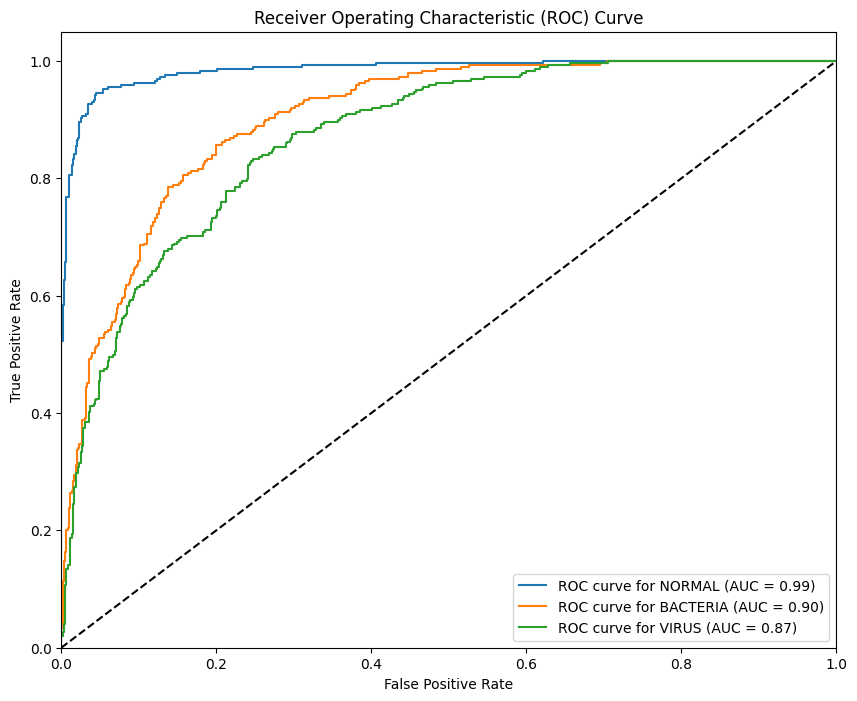

In [14]:
model_paths = ["model_split_0_best.pth","model_split_1_best.pth","model_split_2_best.pth","model_split_3_best.pth","model_split_4_best.pth"]

# Evaluates model using the same random state and data split using randomstate = 42
data_path = "Normalized_Image_Paths.csv"
train_data, test_data = train_test_split(data_path, 0.2)

# Evaluating the model's performance
evaluate_single_model_ensemble(test_data, model_paths)

# Two-Step Binary Classification Model Component Analysis

In [15]:
# Importing the models we will be evaluating
from models import standardCNN
from camModels import denseA3, denseB5, eff4

In [16]:
# This train/test split is used for binary models in particular
def train_test_split1(file_path,test_size, print = False):
    # Load the data
    data = pd.read_csv(file_path)

    # Check the label distribution
    label_counts = data['Labels'].value_counts()
    min_class_count = label_counts.min()
   
    # Create a balanced sample for each label to achieve roughly 33.3% of each label in train and test sets
    data_balanced = pd.concat([
        data[data['Labels'] == label].sample(min_class_count, random_state=42)
        for label in data['Labels'].unique()
    ])

    # Split the balanced data into training and testing sets with a split based on test_size
    train_data, test_data = sk_train_test_split(data_balanced, test_size=test_size, stratify=data_balanced['Labels'], random_state=42)

    # Copying data for disease type split, removing non-infected cases
    disease_type_train = train_data[train_data['Labels'] != 0].copy()
    disease_type_test = test_data[test_data['Labels'] != 0].copy()

    # Changing labels from 1->0 2->1
    label_mapping = {1:0,2:1}
    disease_type_train['Labels'] = disease_type_train['Labels'].map(label_mapping)
    disease_type_test['Labels'] = disease_type_test['Labels'].map(label_mapping)

    # Copying data for disease present split
    disease_train = train_data.copy()
    disease_test = test_data.copy()

    # Turning both disease cases into one class
    disease_train['Labels'] = disease_train['Labels'].apply(lambda x: 1 if x == 2 else x)
    disease_test['Labels'] = disease_test['Labels'].apply(lambda x: 1 if x == 2 else x)

    # Check the label distribution
    disease_train_min = disease_train['Labels'].value_counts().min()
    disease_test_min = disease_test['Labels'].value_counts().min()
    
    # Create a balanced sample for each label to achieve roughly 50% of each label in train and test sets
    disease_train_balanced = pd.concat([
        disease_train[disease_train['Labels'] == label].sample(disease_train_min, random_state=42)
        for label in disease_train['Labels'].unique()
    ])
    disease_test_balanced = pd.concat([
        disease_test[disease_test['Labels'] == label].sample(disease_test_min, random_state=42)
        for label in disease_test['Labels'].unique()
    ])

    # Verify the class balance
    if print:
        print("Training set (disease present) class distribution:\n", disease_type_train['Labels'].value_counts(normalize=True))
        print("Testing set (disease present) class distribution:\n", disease_type_test['Labels'].value_counts(normalize=True))
        print("Training set (disease type) class distribution:\n", disease_train_balanced['Labels'].value_counts(normalize=True))
        print("Testing set (disease type) class distribution:\n", disease_test_balanced['Labels'].value_counts(normalize=True))

    return disease_type_train, disease_type_test, disease_train_balanced, disease_test_balanced

In [17]:
# Code to test the different models
# Testing function
def test_models(model_classes, model_paths, dataloader, threshhold=0):
    y_true = []
    y_pred = []
    y_scores = []  # Stores predicted probabilities for ROC-AUC

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        ensemble_outputs_present = []

        for weights_path in model_paths:
            model_class = model_classes[weights_path]
            model = model_class().to(device)
            model.load_state_dict(torch.load(weights_path, weights_only=True))
            model.eval()
            with torch.no_grad():
                outputs = model(images)
                ensemble_outputs_present.append(F.softmax(outputs, dim=1).cpu().numpy())

        # Average predictions for infection presence
        avg_outputs_present = np.mean(ensemble_outputs_present, axis=0)
        y_scores.extend(avg_outputs_present[:, 1].tolist())  # Store positive class probabilities

        if threshhold:
            final_predictions = (avg_outputs_present[:, 1] > threshhold).astype("int32")
        else:
            final_predictions = np.argmax(avg_outputs_present, axis=1)  # Default: non-infected

        y_pred.extend(final_predictions.tolist())
        y_true.extend(labels.cpu().numpy().tolist())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)  # Probabilities for ROC-AUC

    # Compute accuracy
    accuracy = np.mean(y_true == y_pred)

    # Compute ROC-AUC score
    roc_auc = roc_auc_score(y_true, y_scores)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Compute and print the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")

In [18]:
# Data preparation for all individual models in composite model
# csv file containing [Path, Label] for each normalized image
csv_file = 'Normalized_Image_Paths.csv'
# Split the data into training and testing (90-10) while maintaining balanced classes
train_data, test_data, a, b = train_test_split1(csv_file, 0.1)
val_dataset = ImageDataset(test_data, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Dataset for evaluating disease presence model
d_val_dataset = ImageDataset(b, transform=transform)
d_val_loader = DataLoader(d_val_dataset, batch_size=32, shuffle=False)

In [19]:
# Evaluating the all 3 of the disease type classification models as an ensemble on threshholds 0.5 - 0.54
model_paths = [
    'TrainedModels/denseA31.pth','TrainedModels/denseA32.pth','TrainedModels/denseA33.pth','TrainedModels/denseA34.pth',
    'TrainedModels/eff41.pth','TrainedModels/eff42.pth','TrainedModels/eff43.pth','TrainedModels/eff44.pth',
    'TrainedModels/denseB51.pth','TrainedModels/denseB52.pth','TrainedModels/denseB53.pth','TrainedModels/denseB54.pth'
    ]

model_types = {
    'TrainedModels/denseA31.pth': denseA3,'TrainedModels/denseA32.pth': denseA3,'TrainedModels/denseA33.pth': denseA3,'TrainedModels/denseA34.pth': denseA3,
    'TrainedModels/eff41.pth': eff4,'TrainedModels/eff42.pth': eff4,'TrainedModels/eff43.pth': eff4,'TrainedModels/eff44.pth': eff4,
    'TrainedModels/denseB51.pth': denseB5,'TrainedModels/denseB52.pth': denseB5,'TrainedModels/denseB53.pth': denseB5,'TrainedModels/denseB54.pth': denseB5
}

# Running for entire model ensemble
print("threshhold = 0.5:")
test_models(model_types, model_paths, val_loader, threshhold = 0.5)
print("threshhold = 0.51:")
test_models(model_types, model_paths, val_loader, threshhold = 0.51)
print("threshhold = 0.52:")
test_models(model_types, model_paths, val_loader, threshhold = 0.52)
print("threshhold = 0.53:")
test_models(model_types, model_paths, val_loader, threshhold = 0.53)
print("threshhold = 0.54:")
test_models(model_types, model_paths, val_loader, threshhold = 0.54)

threshhold = 0.5:

Confusion Matrix:
 [[117  32]
 [ 30 120]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7959    0.7852    0.7905       149
           1     0.7895    0.8000    0.7947       150

    accuracy                         0.7926       299
   macro avg     0.7927    0.7926    0.7926       299
weighted avg     0.7927    0.7926    0.7926       299

Accuracy: 0.7926
ROC-AUC Score: 0.8663
threshhold = 0.51:

Confusion Matrix:
 [[119  30]
 [ 30 120]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7987    0.7987    0.7987       149
           1     0.8000    0.8000    0.8000       150

    accuracy                         0.7993       299
   macro avg     0.7993    0.7993    0.7993       299
weighted avg     0.7993    0.7993    0.7993       299

Accuracy: 0.7993
ROC-AUC Score: 0.8663
threshhold = 0.52:

Confusion Matrix:
 [[120  29]
 [ 30 120]]

Classification Report:
         

In [20]:
# Evaluating densenet-121 ensemble
model_paths1 = ['TrainedModels/denseA31.pth','TrainedModels/denseA32.pth','TrainedModels/denseA33.pth','TrainedModels/denseA34.pth']    
model_types1 = {'TrainedModels/denseA31.pth': denseA3,'TrainedModels/denseA32.pth': denseA3,'TrainedModels/denseA33.pth': denseA3,'TrainedModels/denseA34.pth': denseA3}

print("threshhold = 0.5:")
test_models(model_types1, model_paths1, val_loader, threshhold = 0.5)
print("threshhold = 0.51:")
test_models(model_types1, model_paths1, val_loader, threshhold = 0.51)
print("threshhold = 0.52:")
test_models(model_types1, model_paths1, val_loader, threshhold = 0.52)
print("threshhold = 0.53:")
test_models(model_types1, model_paths1, val_loader, threshhold = 0.53)
print("threshhold = 0.54:")
test_models(model_types1, model_paths1, val_loader, threshhold = 0.54)


threshhold = 0.5:

Confusion Matrix:
 [[108  41]
 [ 27 123]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8000    0.7248    0.7606       149
           1     0.7500    0.8200    0.7834       150

    accuracy                         0.7726       299
   macro avg     0.7750    0.7724    0.7720       299
weighted avg     0.7749    0.7726    0.7720       299

Accuracy: 0.7726
ROC-AUC Score: 0.8416
threshhold = 0.51:

Confusion Matrix:
 [[108  41]
 [ 29 121]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7883    0.7248    0.7552       149
           1     0.7469    0.8067    0.7756       150

    accuracy                         0.7659       299
   macro avg     0.7676    0.7657    0.7654       299
weighted avg     0.7675    0.7659    0.7655       299

Accuracy: 0.7659
ROC-AUC Score: 0.8416
threshhold = 0.52:

Confusion Matrix:
 [[109  40]
 [ 30 120]]

Classification Report:
         

In [21]:
# Evaluating denseNet-169 ensemble
model_paths2 = ['TrainedModels/denseB51.pth','TrainedModels/denseB52.pth','TrainedModels/denseB53.pth','TrainedModels/denseB54.pth']
model_types2 = {'TrainedModels/denseB51.pth': denseB5,'TrainedModels/denseB52.pth': denseB5,'TrainedModels/denseB53.pth': denseB5,'TrainedModels/denseB54.pth': denseB5}

print("threshhold = 0.5:")
test_models(model_types2, model_paths2, val_loader, threshhold = 0.5)
print("threshhold = 0.51:")
test_models(model_types2, model_paths2, val_loader, threshhold = 0.51)
print("threshhold = 0.52:")
test_models(model_types2, model_paths2, val_loader, threshhold = 0.52)
print("threshhold = 0.53:")
test_models(model_types2, model_paths2, val_loader, threshhold = 0.53)
print("threshhold = 0.54:")
test_models(model_types2, model_paths2, val_loader, threshhold = 0.54)

threshhold = 0.5:

Confusion Matrix:
 [[107  42]
 [ 27 123]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7985    0.7181    0.7562       149
           1     0.7455    0.8200    0.7810       150

    accuracy                         0.7692       299
   macro avg     0.7720    0.7691    0.7686       299
weighted avg     0.7719    0.7692    0.7686       299

Accuracy: 0.7692
ROC-AUC Score: 0.8545
threshhold = 0.51:

Confusion Matrix:
 [[108  41]
 [ 27 123]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8000    0.7248    0.7606       149
           1     0.7500    0.8200    0.7834       150

    accuracy                         0.7726       299
   macro avg     0.7750    0.7724    0.7720       299
weighted avg     0.7749    0.7726    0.7720       299

Accuracy: 0.7726
ROC-AUC Score: 0.8545
threshhold = 0.52:

Confusion Matrix:
 [[109  40]
 [ 28 122]]

Classification Report:
         

In [22]:
# Evaluating EfficientNetB-0 Ensemble
model_paths3 = ['TrainedModels/eff41.pth','TrainedModels/eff42.pth','TrainedModels/eff43.pth','TrainedModels/eff44.pth']
model_types3 = {'TrainedModels/eff41.pth': eff4,'TrainedModels/eff42.pth': eff4,'TrainedModels/eff43.pth': eff4,'TrainedModels/eff44.pth': eff4}

print("threshhold = 0.5:")
test_models(model_types3, model_paths3, val_loader, threshhold = 0.5)
print("threshhold = 0.51:")
test_models(model_types3, model_paths3, val_loader, threshhold = 0.51)
print("threshhold = 0.52:")
test_models(model_types3, model_paths3, val_loader, threshhold = 0.52)
print("threshhold = 0.53:")
test_models(model_types3, model_paths3, val_loader, threshhold = 0.53)
print("threshhold = 0.54:")
test_models(model_types3, model_paths3, val_loader, threshhold = 0.54)  

threshhold = 0.5:

Confusion Matrix:
 [[117  32]
 [ 34 116]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7748    0.7852    0.7800       149
           1     0.7838    0.7733    0.7785       150

    accuracy                         0.7793       299
   macro avg     0.7793    0.7793    0.7793       299
weighted avg     0.7793    0.7793    0.7793       299

Accuracy: 0.7793
ROC-AUC Score: 0.8593
threshhold = 0.51:

Confusion Matrix:
 [[119  30]
 [ 35 115]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7727    0.7987    0.7855       149
           1     0.7931    0.7667    0.7797       150

    accuracy                         0.7826       299
   macro avg     0.7829    0.7827    0.7826       299
weighted avg     0.7829    0.7826    0.7826       299

Accuracy: 0.7826
ROC-AUC Score: 0.8593
threshhold = 0.52:

Confusion Matrix:
 [[120  29]
 [ 35 115]]

Classification Report:
         

In [23]:
# Evaluating ensemble used to detect disease presence 
model_paths4 = ['TrainedModels/standard1.pth','TrainedModels/standard2.pth','TrainedModels/standard3.pth','TrainedModels/standard4.pth','TrainedModels/standard5.pth']
model_types4 = {'TrainedModels/standard1.pth': standardCNN,'TrainedModels/standard2.pth': standardCNN,'TrainedModels/standard3.pth': standardCNN,'TrainedModels/standard4.pth': standardCNN,'TrainedModels/standard5.pth': standardCNN}

test_models(model_types4, model_paths4, d_val_loader)


Confusion Matrix:
 [[142   7]
 [  5 144]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9660    0.9530    0.9595       149
           1     0.9536    0.9664    0.9600       149

    accuracy                         0.9597       298
   macro avg     0.9598    0.9597    0.9597       298
weighted avg     0.9598    0.9597    0.9597       298

Accuracy: 0.9597
ROC-AUC Score: 0.9904


# Individual CAM (Class Activation Map) Generation
No interpolation occurs here, CAMs are generated individually for each model (ensemble free), and are pulled directly from model layers

In [24]:
# Finds the label of the sample in question from the CSV file containing paths and labels
def get_label(csv_file, target_path):
    with open(csv_file, newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        for row in reader:
            if row[0] == target_path:
                return int(row[1])
    return None  # Return None if the path is not found

# This function runs the function to generate a CAM model. These are inbuilt functions exclusive to the 
# models stored in the camModels folder
def camtest(modelType, image_path, model_path, resolution):
    # Taking the image and turning it into a tensor for the model
    image = Image.open(image_path).convert("L")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Declares the model, uses the tag 'resolution' to determine which layer the CAM will be generated from
    model = modelType(dropout_rate=0.5,hook_layer=resolution).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    # Getting the class label to run generate_cam function
    imageClass = get_label('Normalized_Image_Paths.csv', image_path)
    print(imageClass)

    # Running the tensor through the model
    logits = model(input_tensor)
    cam = model.generate_cam(imageClass, resolution)

    # Ensure tensors are moved to CPU before visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(input_tensor.squeeze().cpu().numpy(), cmap='gray', alpha=0.5)  # Original grayscale image
    plt.imshow(cam, cmap='jet', alpha=0.5)  # Overlay CAM
    plt.colorbar()
    plt.show()

In [25]:
# Declaring model paths and the images used for the camtest
model_path1 = 'TrainedModels/denseA31.pth'
model_path2 = 'TrainedModels/denseB51.pth'
model_path3 = 'TrainedModels/eff41.pth'
# Change this number to change the image number you would like to run an analysis on
image_number = 6
image_path = 'NormalizedXRays/image_'+ str(image_number)+'.jpeg'
# inputs for resolution to get different sized CAM maps: '7x7' '14x14' '28x28'
resOne = '7x7'
resTwo = '14x14'
resolution = '28x28'

1


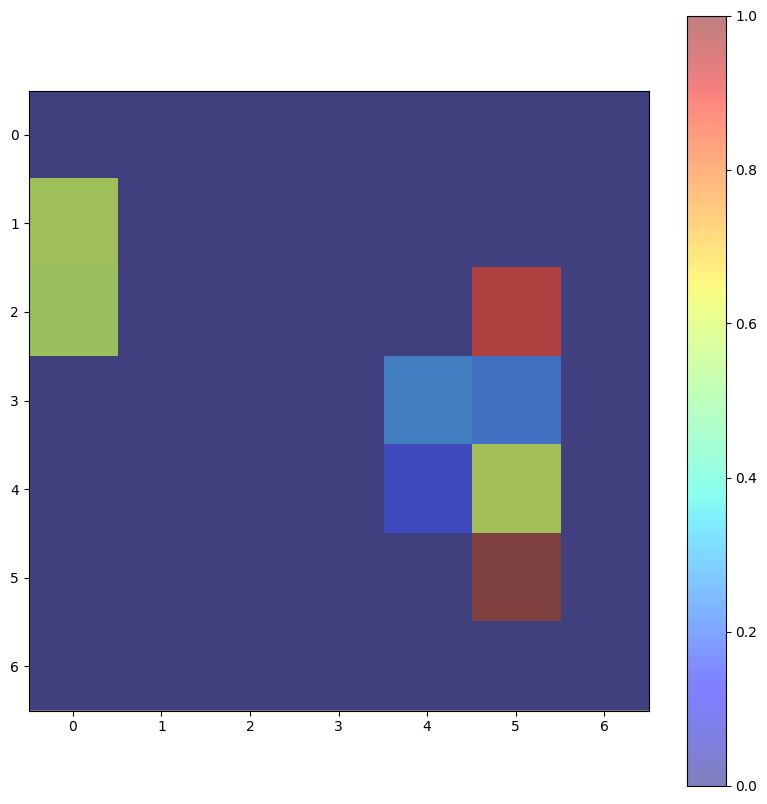

1


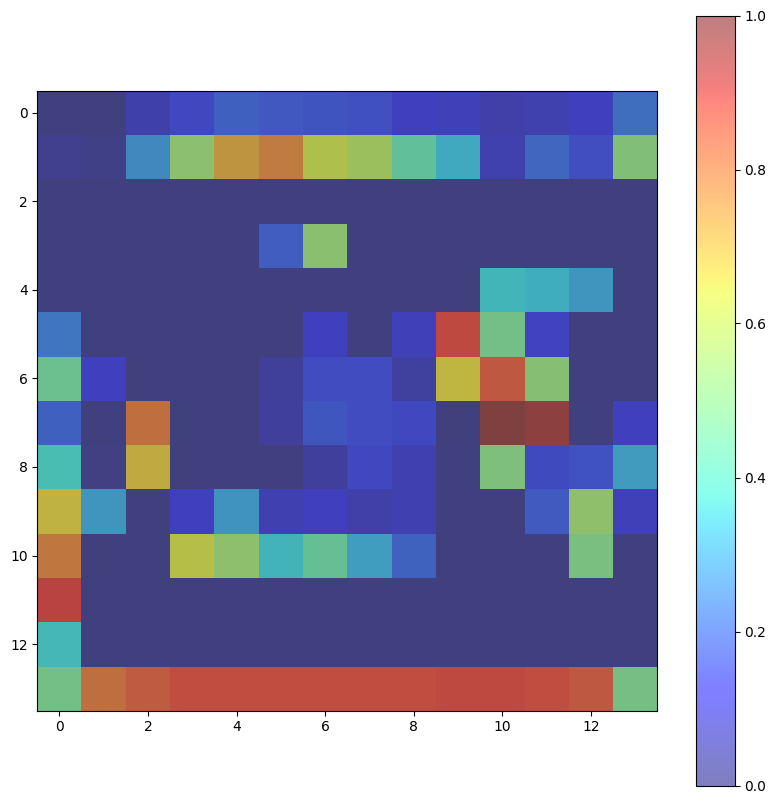

1


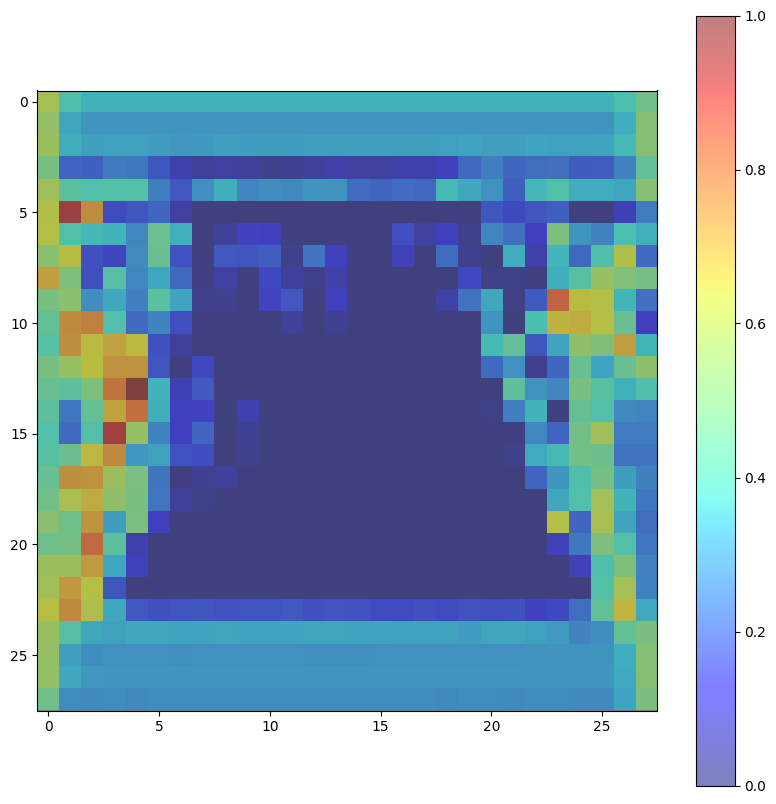

In [26]:
# Get CAM for DenseNet-121 transfer model
camtest(denseA3, image_path, model_path1, resOne)
camtest(denseA3, image_path, model_path1, resTwo)
camtest(denseA3, image_path, model_path1, resolution)

1


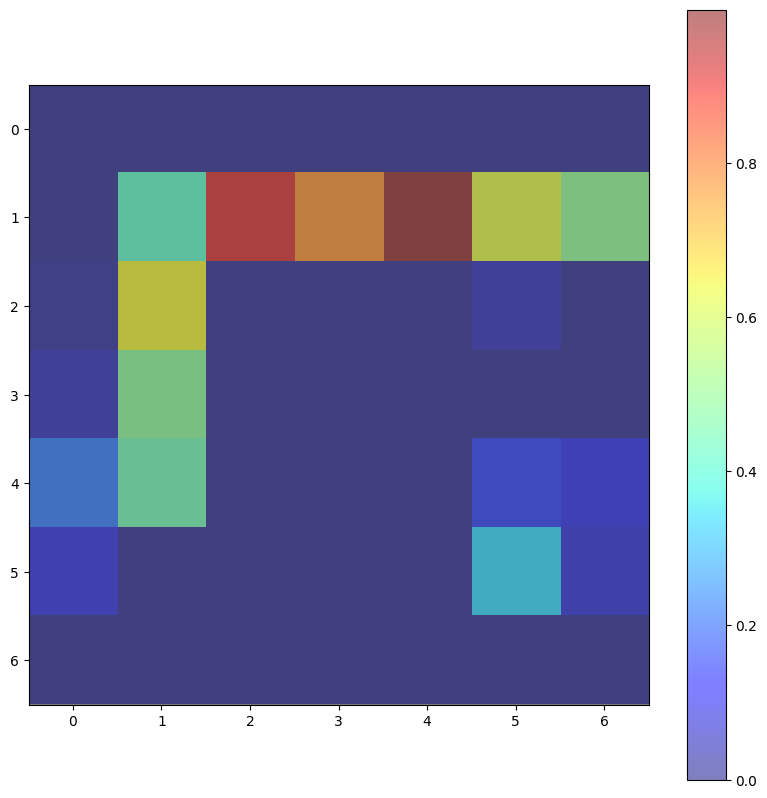

1


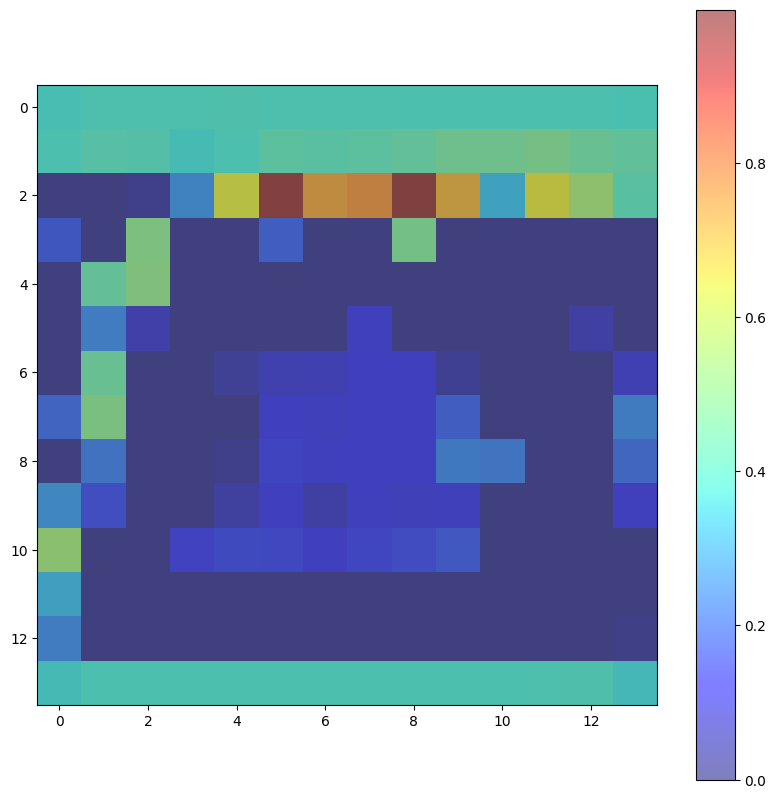

1


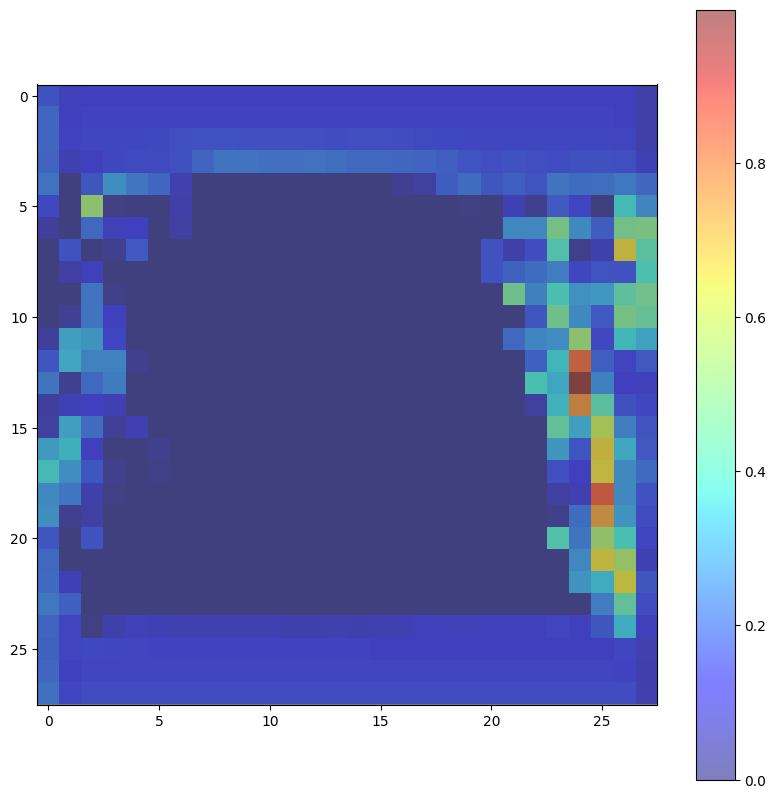

In [27]:
# Get CAM for DenseNet-169 transfer model
camtest(denseB5, image_path, model_path2, resOne)
camtest(denseB5, image_path, model_path2, resTwo)
camtest(denseB5, image_path, model_path2, resolution)

1


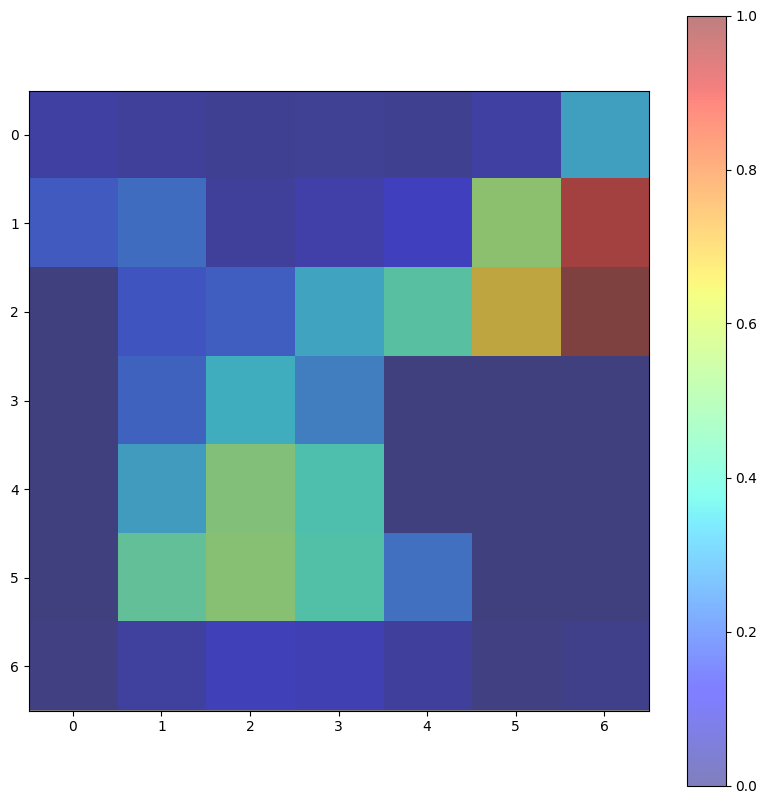

1


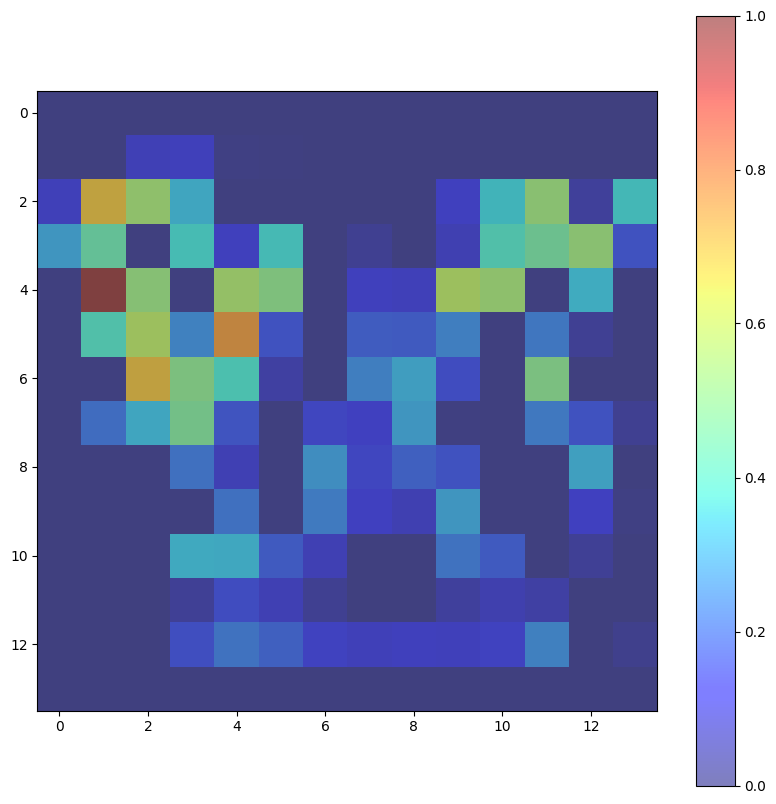

1


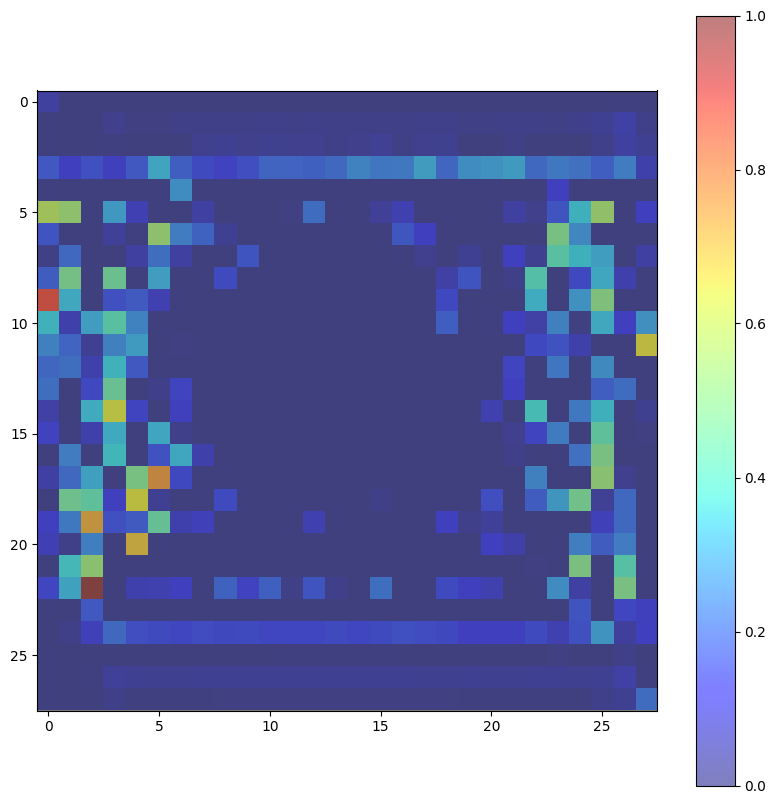

In [28]:
# Get CAM for EfficientNetB-0 transfer model
camtest(eff4, image_path, model_path3, resOne)
camtest(eff4, image_path, model_path3, resTwo)
camtest(eff4, image_path, model_path3, resolution)

In [29]:
# Generate CAM function for the models distinguishing disease type
def generate_cam(model, image_path):
    """
    Generates and visualizes a Class Activation Map (CAM) for a specific class index.

    Args:
        model (nn.Module): The trained CNN model.
        image_path (str): Path to the input image.
        class_idx (int, optional): The class index for which to generate CAM.

    Returns:
        PIL.Image: Image with the CAM overlay.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    # Getting the item class
    class_idx = get_label("Normalized_Image_Paths.csv",image_path)

    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])
    original_image = Image.open(image_path).convert("L")  # Convert to grayscale
    input_tensor = transform(original_image).unsqueeze(0).to(device)  # Add batch dimension

    # Forward pass to extract features from conv3
    activation = None
    def hook_fn(module, input, output):
        nonlocal activation
        activation = output.detach()  # Store feature maps safely

    hook = model.conv3.register_forward_hook(hook_fn)
    with torch.no_grad():
        output = model(input_tensor)
    hook.remove()

    # Ensure activation was captured
    if activation is None:
        raise ValueError("Activation hook did not capture any output!")

    # Determine the class index (if not provided, use predicted class)
    if class_idx is None:
        class_idx = torch.argmax(output, dim=1).item()

    # Ensure the class index is within bounds
    class_idx = min(class_idx, model.fc2.out_features - 1)

    # Get the weights for the target class from fc2
    fc_weights = model.fc2.weight[class_idx].detach()

    # Validate fc_weights
    if torch.isnan(fc_weights).any() or torch.isinf(fc_weights).any():
        raise ValueError("fc_weights contain NaN or Inf values!")

    # Generate CAM by weighted sum of feature maps
    cam = torch.zeros(activation.shape[2:], device=device)
    for i in range(activation.shape[1]):  # Iterate over channels
        cam += fc_weights[i] * activation[0, i, :, :]

    cam = torch.relu(cam)  # Apply ReLU to remove negative values

    # Normalize CAM for visualization
    cam = cam.cpu().numpy()

    if cam.max() > cam.min():  # Avoid division by zero
        cam -= cam.min()
        cam /= cam.max()
    else:
        cam = np.zeros_like(cam)  # Default blank heatmap

    # Handle NaN or Inf values safely
    cam = np.nan_to_num(cam, nan=0.0, posinf=1.0, neginf=0.0)

    # Resize CAM to the original image dimensions
    cam_image = Image.fromarray((cam * 255).astype('uint8')).resize(original_image.size, Image.LANCZOS)

    # Convert CAM to heatmap
    heatmap = cam_image.convert("L")

    # Overlay CAM onto the original image
    overlay = Image.blend(original_image.convert("L"), heatmap, alpha=0.5)

    # Enhance contrast to make CAM more visible
    enhancer = ImageEnhance.Contrast(overlay)
    overlay = enhancer.enhance(1.5)

    # Display both the heatmap and overlay
    plt.figure(figsize=(12, 6))

    # Display Heatmap
    plt.subplot(1, 2, 1)
    plt.imshow(overlay)
    plt.title(f'Class Activation Map Heatmap for {class_idx} Class')
    plt.axis("off")

    # Display Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f'Overlay for {class_idx} Class')
    plt.axis("off")

    # Adjust layout to prevent title cut off
    plt.subplots_adjust(top=0.85, bottom=0.1, left=0.1, right=0.9)

    plt.tight_layout()
    plt.show()

    return overlay, heatmap

def run_cam(model_class, weights_path, image_path):
    image = Image.open(image_path).convert("L")
    input_tensor = transform(image).unsqueeze(0).to(device)
    model = model_class().to(device)
    model.load_state_dict(torch.load(weights_path, weights_only=True))
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
    overlay, heatmap = generate_cam(model, image_path)
    return

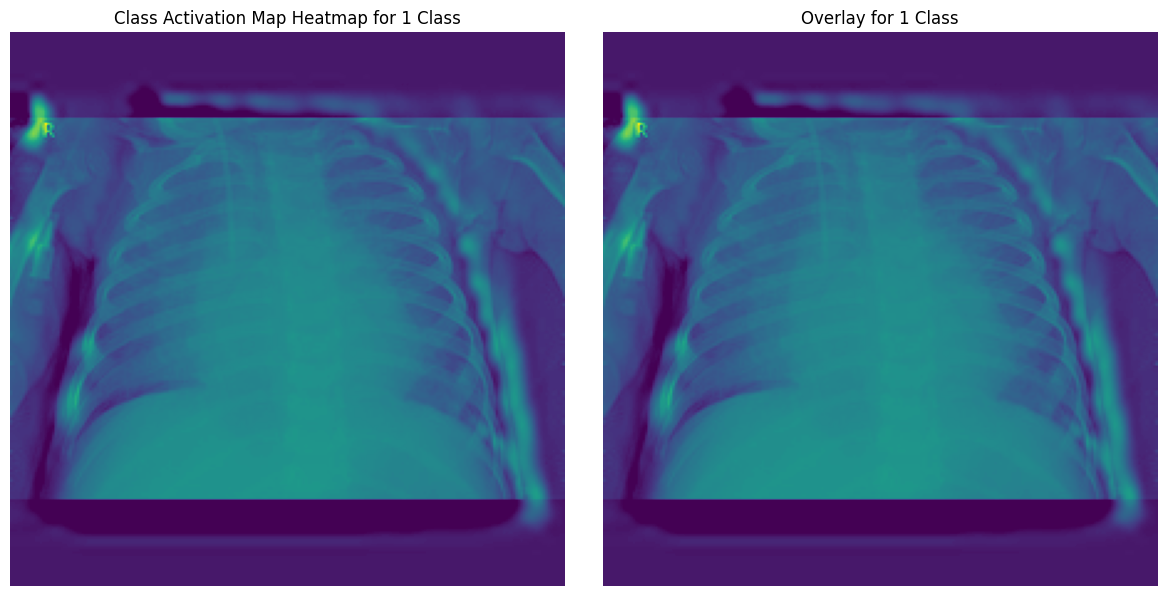

In [30]:
# Run the CAM for the disease type model using the same image as those for the disease type models
disease_type_model_path = 'TrainedModels/standard1.pth'
run_cam(standardCNN, disease_type_model_path, image_path)


# Two-Step Binary Classification Model Analysis

In [31]:
# Code to test the entire ensemble model
def validate_models(validation_set, model_paths, model_types, threshhold = 0.5):
    # Extract lists for both ensemble stages
    present_model_paths = model_paths['infection_present_models']
    type_model_paths = model_paths['infection_type_models']

    # Create dataset and dataloader for the validation data
    test_dataset = ImageDataset(validation_set, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    all_labels = []
    all_final_predictions = []
    
    # First stage: Predict whether infection is present
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        ensemble_outputs_present = []

        for weights_path in present_model_paths:
            model = standardCNN().to(device)
            model.load_state_dict(torch.load(weights_path, weights_only=True))
            model.eval()
            with torch.no_grad():
                outputs = model(images)
                ensemble_outputs_present.append(F.softmax(outputs, dim=1).cpu().numpy())

        # Average predictions for infection presence
        avg_outputs_present = np.mean(ensemble_outputs_present, axis=0)
        is_infected = (np.argmax(avg_outputs_present, axis=1) == 1)

        # Second stage: Classify type of infection if present
        final_predictions = np.zeros(images.shape[0], dtype=int) # Default: non-infected  np.argmax(avg_outputs_present, axis=1)

        if np.any(is_infected):
            is_infected = torch.tensor(is_infected, device=device, dtype=torch.bool)
            images_infected = images[is_infected]
            ensemble_outputs_type = []

            for weights_path in type_model_paths:
                modeltype = model_types[weights_path]
                model = modeltype().to(device)
                model.load_state_dict(torch.load(weights_path, weights_only=True))
                model.eval()
                with torch.no_grad():
                    outputs = model(images_infected)
                    ensemble_outputs_type.append(F.softmax(outputs, dim=1).cpu().numpy())

            avg_outputs_type = np.mean(ensemble_outputs_type, axis=0)

            # Switch between argmax and custom threshhold, comment out one
            # type_predictions = np.argmax(avg_outputs_type, axis=1)
            type_predictions = (avg_outputs_type[:, 1] > threshhold).astype("int32")
            
            final_predictions[is_infected.cpu().numpy()] = type_predictions + 1  # Assign correct class labels

        all_final_predictions.extend(final_predictions)
        all_labels.extend(labels.cpu().numpy())

    # Convert to NumPy arrays
    all_labels = np.array(all_labels)
    all_final_predictions = np.array(all_final_predictions)


    # Declaring Class Names
    class_names = ['NORMAL', 'BACTERIA', 'VIRUS']

    # Compute Metrics
    conf_matrix = confusion_matrix(all_labels, all_final_predictions)
    class_report = classification_report(all_labels, all_final_predictions, target_names=class_names, digits=4)

    # Print results
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{class_report}")


    return {"conf_matrix": conf_matrix, "class_report": class_report}

In [32]:
# Entire ensemble model being validated at various threshholds
file_path = 'Normalized_Image_Paths.csv'

test_data, train_data = train_test_split(file_path, 0.1)

# Different models are placed on different lines that way they can each be commented out to see where their strengths lie.
model_paths = {
    'infection_present_models': ['TrainedModels/standard1.pth','TrainedModels/standard2.pth','TrainedModels/standard3.pth',
                                    'TrainedModels/standard4.pth','TrainedModels/standard5.pth'],
    'infection_type_models': [
                            'TrainedModels/denseA31.pth','TrainedModels/denseA32.pth','TrainedModels/denseA33.pth','TrainedModels/denseA34.pth',
                            'TrainedModels/eff41.pth','TrainedModels/eff42.pth','TrainedModels/eff43.pth','TrainedModels/eff44.pth',
                            'TrainedModels/denseB51.pth','TrainedModels/denseB52.pth','TrainedModels/denseB53.pth','TrainedModels/denseB54.pth'
    ]
}

model_types = {
    'TrainedModels/denseA31.pth': denseA3,'TrainedModels/denseA32.pth': denseA3,'TrainedModels/denseA33.pth': denseA3,'TrainedModels/denseA34.pth': denseA3,
    'TrainedModels/eff41.pth': eff4,'TrainedModels/eff42.pth': eff4,'TrainedModels/eff43.pth': eff4,'TrainedModels/eff44.pth': eff4,
    'TrainedModels/denseB51.pth': denseB5,'TrainedModels/denseB52.pth': denseB5,'TrainedModels/denseB53.pth': denseB5,'TrainedModels/denseB54.pth': denseB5
}

# Tests the entire ensemble model on different threshholds.
validate_models(train_data, model_paths, model_types, 0.5)
validate_models(train_data, model_paths, model_types, 0.51)
validate_models(train_data, model_paths, model_types, 0.52)
validate_models(train_data, model_paths, model_types, 0.53)
validate_models(train_data, model_paths, model_types, 0.54)

Confusion Matrix:
[[142   0   7]
 [  1 117  31]
 [  6  30 114]]
Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9530    0.9530    0.9530       149
    BACTERIA     0.7959    0.7852    0.7905       149
       VIRUS     0.7500    0.7600    0.7550       150

    accuracy                         0.8326       448
   macro avg     0.8330    0.8328    0.8328       448
weighted avg     0.8328    0.8326    0.8327       448

Confusion Matrix:
[[142   0   7]
 [  1 119  29]
 [  6  30 114]]
Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9530    0.9530    0.9530       149
    BACTERIA     0.7987    0.7987    0.7987       149
       VIRUS     0.7600    0.7600    0.7600       150

    accuracy                         0.8371       448
   macro avg     0.8372    0.8372    0.8372       448
weighted avg     0.8371    0.8371    0.8371       448

Confusion Matrix:
[[142   0   7]
 [  1 120  28]
 [  6  30 114]]


{'conf_matrix': array([[142,   1,   6],
        [  1, 123,  25],
        [  6,  33, 111]], dtype=int64),
 'class_report': '              precision    recall  f1-score   support\n\n      NORMAL     0.9530    0.9530    0.9530       149\n    BACTERIA     0.7834    0.8255    0.8039       149\n       VIRUS     0.7817    0.7400    0.7603       150\n\n    accuracy                         0.8393       448\n   macro avg     0.8394    0.8395    0.8391       448\nweighted avg     0.8393    0.8393    0.8389       448\n'}

# Bilaterally Interpolated CAM Analysis for Two-Step Binary Classification Model

In [33]:
# Here are the functions used to generate the CAM for the full ensemble model
def camtest(modelType, image_path, model_path, imageClass, resolution):
    image = Image.open(image_path).convert("L")
    input_tensor = transform(image).unsqueeze(0).to(device)

    model = modelType(dropout_rate=0.5,hook_layer=resolution).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    logits = model(input_tensor)
    cam = model.generate_cam(imageClass, resolution)

    return cam

def run_ensemble(model_paths, model_types, image_path, CAM, resolution = '7x7'):
    image = Image.open(image_path).convert("L")
    input_tensor = transform(image).unsqueeze(0).to(device)
   
    heatmaps = []
    ensemble_outputs = []
    df = pd.read_csv('Normalized_Image_Paths.csv')
    label = int(df.loc[df['Paths'] == image_path, 'Labels'].values[0])
    for path in model_paths['infection_present_models']:
        model_class = model_types[path]
        model = model_class().to(device)
        model.load_state_dict(torch.load(path, weights_only=True))
        model.eval()
        with torch.no_grad():
            outputs = model(input_tensor)
            ensemble_outputs.append(F.softmax(outputs, dim=1).cpu().numpy())
        overlay, heatmap = generate_cam(model, image_path)
        heatmaps.append(heatmap)

    ensemble_outputs = np.mean(ensemble_outputs, axis=0)
    predicted_class = np.argmax(ensemble_outputs)
    
    if predicted_class == 0:
        class_mapping = {0: "normal", 1: "bacterial", 2: "viral"}
        print("Predicted Class (Ensemble): normal")
        print(f"Actual Class: {class_mapping.get(label, 'Unknown')}")
        if CAM:
            showCAM(heatmaps, [], image_path)
        return
    
    # Classifying if not no-infection
    type_heatmaps = []
    ensemble_outputs_type = []
    for weights_path in model_paths['infection_type_models']:
        modeltype = model_types[weights_path]
        model = modeltype().to(device)
        model.load_state_dict(torch.load(weights_path, weights_only=True))
        model.eval()
        with torch.no_grad():
            outputs = model(input_tensor)
            ensemble_outputs_type.append(F.softmax(outputs, dim=1).cpu().numpy())
        type_heatmaps.append(camtest(modeltype, image_path, weights_path, label-1, resolution))

    showCAM(heatmaps, type_heatmaps, image_path)
    return

# Uses Bilateral Interpolation
def showCAM(disease_present_CAMS, disease_type_CAMS, image_path):
    # Load the original image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    
    # Compute mean heatmap for disease presence
    mean_present_CAM = np.mean(disease_present_CAMS, axis=0)
    mean_present_CAM = (mean_present_CAM - np.min(mean_present_CAM)) / (np.max(mean_present_CAM) - np.min(mean_present_CAM) + 1e-8)

    # Resize heatmap to match image dimensions
    heatmap_size = (image.shape[1], image.shape[0])
    mean_present_CAM = cv2.resize(mean_present_CAM, heatmap_size)

    # Generate overlayed heatmap for disease presence
    heatmap_present = cv2.applyColorMap((mean_present_CAM * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay_present = cv2.addWeighted(image, 0.5, heatmap_present, 0.5, 0)

    # Check if disease_type_CAMS exists
    has_disease_type = len(disease_type_CAMS) > 0

    if has_disease_type:
        # Compute mean heatmap for disease type
        mean_type_CAM = np.mean(disease_type_CAMS, axis=0)
        mean_type_CAM = (mean_type_CAM - np.min(mean_type_CAM)) / (np.max(mean_type_CAM) - np.min(mean_type_CAM) + 1e-8)
        mean_type_CAM = cv2.resize(mean_type_CAM, heatmap_size)

        # Generate overlayed heatmap for disease type
        heatmap_type = cv2.applyColorMap((mean_type_CAM * 255).astype(np.uint8), cv2.COLORMAP_JET)
        overlay_type = cv2.addWeighted(image, 0.5, heatmap_type, 0.5, 0)

    # Create figure with correct number of rows
    num_rows = 3 if has_disease_type else 2
    fig, axes = plt.subplots(num_rows, 1, figsize=(5, 4 * num_rows), constrained_layout=True)

    # Function to add a properly formatted colorbar
    def add_colorbar(ax, im):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjusted padding for vertical layout
        cbar = fig.colorbar(im, cax=cax, shrink=0.8)  # Keep colorbar compact
        cbar.set_label("Activation Intensity", fontsize=9, labelpad=6)
        cbar.ax.tick_params(labelsize=8)
        cbar.mappable.set_clim(0, 1)  # Normalize colorbar values to [0,1]

    # Original Image
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=12)
    axes[0].axis("off")

    # Disease Presence CAM with colorbar
    im1 = axes[1].imshow(overlay_present, cmap="jet", vmin=0, vmax=1)
    axes[1].set_title("Mean Disease Presence CAM", fontsize=12)
    axes[1].axis("off")
    add_colorbar(axes[1], im1)

    # Only show Disease Type CAM if available
    if has_disease_type:
        im2 = axes[2].imshow(overlay_type, cmap="jet", vmin=0, vmax=1)
        axes[2].set_title("Mean Disease Type CAM", fontsize=12)
        axes[2].axis("off")
        add_colorbar(axes[2], im2)

    plt.show()


In [36]:
# Here is the function call for the full ensemble CAM generation

# Declarations for the models involved in the generation of the CAM model
full_model_paths = {
    'infection_present_models': [
        'TrainedModels/standard1.pth',
        'TrainedModels/standard2.pth',
        'TrainedModels/standard3.pth',
        'TrainedModels/standard4.pth',
        'TrainedModels/standard5.pth'
        ],
    'infection_type_models': [
        'TrainedModels/denseA31.pth','TrainedModels/denseA32.pth','TrainedModels/denseA33.pth','TrainedModels/denseA34.pth',
        'TrainedModels/eff41.pth','TrainedModels/eff42.pth','TrainedModels/eff43.pth','TrainedModels/eff44.pth',
        'TrainedModels/denseB51.pth','TrainedModels/denseB52.pth','TrainedModels/denseB53.pth','TrainedModels/denseB54.pth'
    ]
}
full_model_types = {
    'TrainedModels/standard1.pth': standardCNN,'TrainedModels/standard2.pth': standardCNN,'TrainedModels/standard3.pth': standardCNN,'TrainedModels/standard4.pth': standardCNN,'TrainedModels/standard5.pth': standardCNN,
    'TrainedModels/denseA31.pth': denseA3,'TrainedModels/denseA32.pth': denseA3,'TrainedModels/denseA33.pth': denseA3,'TrainedModels/denseA34.pth': denseA3,
    'TrainedModels/eff41.pth': eff4,'TrainedModels/eff42.pth': eff4,'TrainedModels/eff43.pth': eff4,'TrainedModels/eff44.pth': eff4,
    'TrainedModels/denseB51.pth': denseB5,'TrainedModels/denseB52.pth': denseB5,'TrainedModels/denseB53.pth': denseB5,'TrainedModels/denseB54.pth': denseB5
}

# Runs the CAM model for the same image_path as the other models and for all 3 different resolutions
run_ensemble(full_model_paths, full_model_types, image_path, resOne)
run_ensemble(full_model_paths, full_model_types, image_path, resTwo)
run_ensemble(full_model_paths, full_model_types, image_path, resolution)

TypeError: generate_cam() takes 2 positional arguments but 3 were given